In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from datasets import DatasetDict
from transformers import AutoTokenizer
from collections import Counter
import matplotlib.pyplot as plt

from src.configuration.set_up_config_device import (
    get_allowed_cpu_count,
    set_up_config_device,
    set_up_device,
)
from src.data_processing.loading import load_iob_data
from src.data_processing.tokenization import create_tokenized_dataset
from src.data_processing.collator import make_collator
from src.data_processing.descriptive_statistics import descriptive_statistics
from src.model.transformer import TransformerForNER
from src.model.optimization import get_optimizer_and_scheduler
from src.model.train import (
    train_model,
    plot_train_val_loss,
)
from src.evaluate.evaluate import evaluate_ner_model

/opt/conda/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2025-04-12 14:35:57 - INFO - Logging system initialized


In [3]:
device = set_up_device()
cpu_count = get_allowed_cpu_count()
n_process = set_up_config_device(cpu_count)

2025-04-12 14:35:57 - INFO - Using cuda device
2025-04-12 14:35:57 - INFO - Using 72 CPUs
2025-04-12 14:35:57 - INFO - torch set up to use 36 processes


In [4]:
tokenizer = AutoTokenizer.from_pretrained(
    "GroNLP/bert-base-dutch-cased", add_prefix_space=True
)

In [5]:
BATCH_SIZE = 32
LEARNING_RATE = 5e-5
NB_EPOCHS = 10

In [6]:
MODEL_PARAMETERS = {
    "pad_idx": tokenizer.pad_token_id,
    "vocab_size": tokenizer.vocab_size,
    "hidden_size": 256,
    "n_head": 4,
    "max_len": 512,
    "ffn_hidden": 512,
    "n_layers": 4,
}

# **LOAD & PROCESS DATA**

In [7]:
sentences, labels = load_iob_data("data/raw/train-nl.tsv")

In [8]:
tokenized_dataset, label2id, id2label = create_tokenized_dataset(
    sentences, labels, tokenizer, save_path="data/tokenized/tokenized_dataset.json"
)

Creating json from Arrow format: 100%|██████████| 3/3 [00:00<00:00,  3.80ba/s]

Tokenized dataset saved at: data/tokenized/tokenized_dataset.json


In [9]:
# Split train/test
train_test = tokenized_dataset.train_test_split(test_size=0.2, seed=42)

# Split test into validation/test
val_test = train_test["test"].train_test_split(test_size=0.5, seed=42)

# Recombine into final DatasetDict
split_dataset = DatasetDict(
    {
        "train": train_test["train"],
        "validation": val_test["train"],
        "test": val_test["test"],
    }
)

In [10]:
split_dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1759
    })
    validation: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 220
    })
    test: Dataset({
        features: ['tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 220
    })
})

In [11]:
train_dataset = split_dataset["train"].remove_columns(["tokens", "ner_tags"])
val_dataset = split_dataset["validation"].remove_columns(["tokens", "ner_tags"])

collate_fn = make_collator(tokenizer, label2id)

train_loader = DataLoader(
    train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_fn
)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

# **DESCRIPTIVE STATISTICS**

In [12]:
descriptive_statistics(sentences, labels)

Corpus Summary:
   num_sentences  min_length  mean_length  max_length
0           2199           1   227.498863         703

IOB Tag Statistics (per sentence):
                                 min        mean    max  n_unique_words
B-Organization                   0.0    0.483856    7.0           258.0
B-Organization,B-Place           0.0    0.001364    1.0             2.0
B-Organization,I-Person          0.0    0.001819    2.0             3.0
B-Organization,I-Place           0.0    0.016371    2.0            14.0
B-Person                         0.0    5.238290   47.0          3501.0
B-Person,B-Place                 0.0    0.000910    1.0             2.0
B-Person,I-Place                 0.0    0.011369    1.0             9.0
B-Place                          0.0    1.858572   12.0          1081.0
I-Organization                   0.0    1.435198   25.0           777.0
I-Organization,B-Place           0.0    0.135516    3.0           119.0
I-Organization,I-Person          0.0    0.005912

# **DEFINE & TRAIN MODEL**

In [13]:
model = TransformerForNER(**MODEL_PARAMETERS, num_labels=len(label2id)).to(device)

In [14]:
optimizer, scheduler = get_optimizer_and_scheduler(
    model, train_loader, epochs=NB_EPOCHS
)

In [15]:
train_losses, val_losses = train_model(
    model,
    train_loader,
    val_loader,
    optimizer,
    scheduler=scheduler,
    device=device,
    epochs=NB_EPOCHS,
    save_path="checkpoints/best_model.pt",
)

Epoch 1/10 - Train Loss: 566.7905 | Val Loss: 127.2146
Epoch 2/10 - Train Loss: 111.4767 | Val Loss: 100.6991
Epoch 3/10 - Train Loss: 98.7609 | Val Loss: 93.5039
Epoch 4/10 - Train Loss: 93.1504 | Val Loss: 89.9687
Epoch 5/10 - Train Loss: 89.7411 | Val Loss: 86.4665
Epoch 6/10 - Train Loss: 87.1621 | Val Loss: 85.0252
Epoch 7/10 - Train Loss: 85.5821 | Val Loss: 83.9235
Epoch 8/10 - Train Loss: 84.1348 | Val Loss: 82.9154
Epoch 9/10 - Train Loss: 83.1532 | Val Loss: 81.9555
Epoch 10/10 - Train Loss: 82.6936 | Val Loss: 81.4771


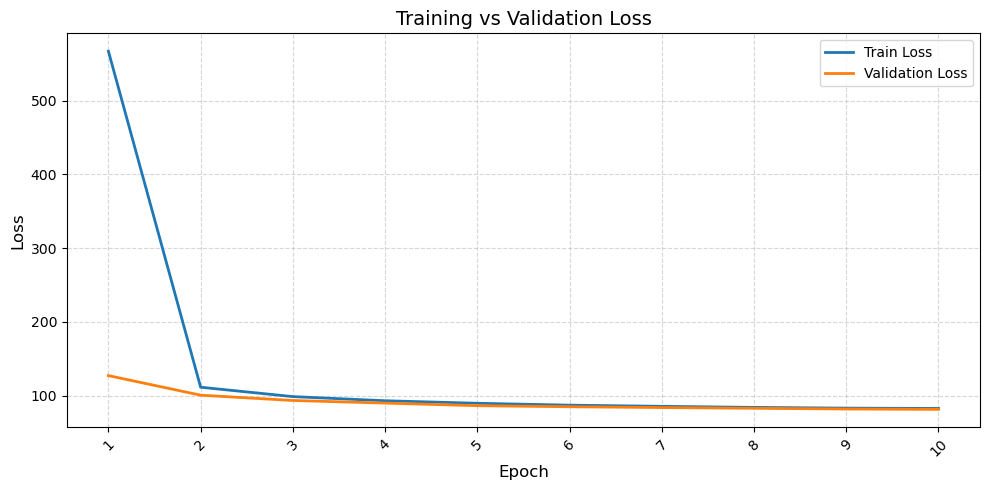

In [16]:
plot_train_val_loss(train_losses, val_losses, title="Training vs Validation Loss")

# **EVALUATE RESULTS**

In [18]:
test_dataset = split_dataset["test"].remove_columns(["tokens", "ner_tags"])

test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, collate_fn=collate_fn)

In [19]:
evaluate_ner_model(model, test_loader, id2label, device=device)

🔍 seqeval classification report:
                      precision    recall  f1-score   support

        Organization     0.0000    0.0000    0.0000       243
Organization,B-Place     0.0000    0.0000    0.0000        31
Organization,I-Place     0.0000    0.0000    0.0000        20
              Person     0.2560    0.0526    0.0872      2017
      Person,B-Place     0.0000    0.0000    0.0000        13
      Person,I-Place     0.0000    0.0000    0.0000        10
               Place     0.2788    0.0488    0.0831       594

           micro avg     0.2606    0.0461    0.0784      2928
           macro avg     0.0764    0.0145    0.0243      2928
        weighted avg     0.2329    0.0461    0.0769      2928


F1-score (micro): 0.0784
